# **Tech Challenge - Fase 4 - Data Viz and Production Model**

Grupo 56 - Integrantes

- Eduardo Parada
- Felipe Gondin Lima
- Raphael Baldassin
- Sabrina Bet


## **Desafios do Tech Challenge**

- Criar um Dashboard interativo com ferramentas à sua escolha.
- Seu Dashboard deve fazer parte de um Storytelling que traga insights relevantes sobre a variação do preço do petróleo, como situações geopolíticas, crises econômicas, demanda global por energia e etc. Isso pode te ajudar com seu modelo. É obrigatório que você traga pelo menos 4 insights neste desafio.
- Criar um modelo de Machine Learning que faça a previsão do preço do petróleo diariamente(lembre-se de time series). Esse modelo deve estar contemplado em seu Storytelling e deve conter o código que você trabalhou, analisando as performances do modelo.
- Criar um plano para fazer o deploy em produção do modelo, com as ferramentas que são necessárias.
Faça um MVP do seu modelo em produção uilizando o Streamlit.

## **WebScraping dos dados**

Base de dados IPEA - Preço do barril de petróleo

http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view


In [43]:
#Importando as bibliotecas para webscraping

import requests #utilizada para fazer requisições HTTP
from bs4 import BeautifulSoup #extração de dados de documentos HTML e XML
import pandas as pd
from datetime import datetime

In [44]:
#Função com atualização de DataFrame

def atualizar_dataframe(df, new_data):
  #Converte a coluna 'Data' para datetime
  df['data'] = pd.to_datetime(df['data'],dayfirst=True)
  new_data['data']= pd.to_datetime(new_data['data'], dayfirst=True)

  #Encontra a data mais recente no dataframe existente
  last_date = df['data'].max()

  #Filtra as novas linhas que são mais recentes do que a ultima data
  new_rows = new_data[new_data['data']>last_date]

  #Concatena os novos dados com o dataframe existente se houver novas linhas
  if not new_rows.empty:
    update_df = pd.concat([df,new_rows], ignore_index=True)
  else:
    update_df = df

  return update_df

#Criando uma variável com o site do IPEA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

#Fazer a requisição ao site e captura da resposta
response = requests.get(url)

#Verificando se a requisição foi bem sucedida
if response.status_code == 200:

#Cria um objeto Beautifulsoup para analisar o HTML
  soup = BeautifulSoup(response.text, 'html.parser')

  #Analisar o HTML procurando pela tabela
  table = soup.find('table',{'id':'grd_DXMainTable'})

  #Usar o pandas para ler a tabela direto no HTML e transformar em um dataframe
  new_df = pd.read_html(str(table),header=0)[0] #1
  new_df = new_df.rename(columns={'Data': 'data', 'Preço - petróleo bruto - Brent (FOB)': 'preco'})

  #verifica se o arquivo do dataframe existe e carrega, ou cria um novo dataframe se nao exitir
  path ='/content/ipea_bruto.csv'
  try:
    existing_df = pd.read_csv(path)
  except FileNotFoundError:
    existing_df = new_df #se o arquivo não existir, considere os dados atuais como o dataframe existente

  #Atualiza o dataframe existente com novos dados (carga incremental)
  update_df = atualizar_dataframe(existing_df,new_df)

  #Salva o dataframe atualizado para o arquivo
  update_df.to_csv(path, index = False)

  #Mostra as primeiras linhas do df atualizado
  update_df.head()

else:
    print('Falha ao acessar a página: Status Code', response.status_code)

#TOMAR MUITO CUIDADO COM A IDENTAÇÃO DO CÓDIGO, SENÃO ELE NÃO FUNCIONA

In [45]:
def remover_tabela(nome_tabela):
    """Remove uma tabela do banco de dados."""
    conn = conexao()
    try:
        with conn.cursor() as cursor:
            cursor.execute(f"DROP TABLE IF EXISTS {nome_tabela}")
        conn.commit()
        print(f"Tabela '{nome_tabela}' removida com sucesso.")
    except Exception as e:
        conn.rollback()
        print(f"Erro ao remover tabela '{nome_tabela}': {str(e)}")
    finally:
        conn.close()

# Exemplo de uso
#tabela_a_remover = 'public.previsao2'
#remover_tabela(tabela_a_remover) #SÓ USAR EM CASO DE NECESSIDADE, CUIDADO PARA NÃO PERDER OS DADOS

In [46]:
#Verificando como ficou a base após a captura dos dados

df_base = pd.read_csv('/content/ipea_bruto.csv')
df_base.head()

,data,preco
0,2024-01-22,8170
1,2024-01-19,8071
2,2024-01-18,8104
3,2024-01-17,7888
4,2024-01-16,8015


In [47]:
#Preparando os dados para serem inseridos no banco de dados

df_base['data'] = pd.to_datetime(df_base['data'])
df_base['preco']= df_base['preco']/100

In [48]:
df_base.info()
df_base.head()
df_base.to_csv('BDBase.csv', sep=";")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11092 non-null  datetime64[ns]
 1   preco   11092 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.4 KB


## **Inserindo os dados capturados no banco de dados PostgreSQL**

In [49]:
#Instalando psycopg2 para acesso ao banco de dados

!pip install psycopg2

In [50]:
import psycopg2 as ps
from psycopg2 import sql

In [51]:
#criar uma função de conexão com banco de dados

def conexao():
    try:
        conn = ps.connect(
            host="db-previsao.cbnbr78bfmrx.us-east-1.rds.amazonaws.com",
            port=5432,
            database="bd_covid",
            user="postgres",
            password="covid123"
        )
        return conn
    except (Exception, ps.Error) as error:
        print("Erro ao conectar ao banco de dados", error)
        raise

In [52]:
#Leitura de dados do banco de dados

#Cria uma tabela nova para inserção dos dados do webscraping

def criar_tabela():
    conn = conexao()
    with conn.cursor() as cursor:
      cursor.execute("""
            CREATE TABLE IF NOT EXISTS public.previsao2 (
                data DATE UNIQUE,
                preco DECIMAL(10, 2)
            )
        """)
    conn.commit()
    conn.close()

#Leitura que retorna todos os dados da tabela
def ler_dados():
    conn = conexao()
    with conn.cursor() as cursor:
        cursor.execute("SELECT * FROM public.previsao2")
        colunas = [desc[0] for desc in cursor.description]
        dados_do_sql = cursor.fetchall()
        dados_do_sql = pd.DataFrame(dados_do_sql, columns=colunas)
    conn.close()
    return dados_do_sql


In [53]:
#executando a criação da tabela
criar_tabela()

In [54]:
#Lendo os dados da tabela criada
ler_dados()

,data,preco
0,2024-01-22,81.70
1,2024-01-19,80.71
2,2024-01-18,81.04
3,2024-01-17,78.88
4,2024-01-16,80.15
...,...,...
11087,1987-05-26,18.63
11088,1987-05-25,18.60
11089,1987-05-22,18.55
11090,1987-05-21,18.45


In [55]:
#Criando as funções que irão alimentar a base de dados com o df_base

def inserir_dados(df):
    conn = conexao()
    try:
        with conn.cursor() as cursor:
            # Utilize uma única instrução SQL com executemany
            cursor.executemany("""
                INSERT INTO public.previsao2 (data, preco)
                VALUES (%s, %s)
                ON CONFLICT (data) DO NOTHING
            """, df[['data', 'preco']].values)

        print("Inserção bem-sucedida.")
        conn.commit()

    except Exception as e:
        conn.rollback()
        print(f"Erro ao inserir dados na tabela: {str(e)}")

    finally:
        conn.close()

In [56]:
#inserir_dados(df_base)

In [57]:
ler_dados()

,data,preco
0,2024-01-22,81.70
1,2024-01-19,80.71
2,2024-01-18,81.04
3,2024-01-17,78.88
4,2024-01-16,80.15
...,...,...
11087,1987-05-26,18.63
11088,1987-05-25,18.60
11089,1987-05-22,18.55
11090,1987-05-21,18.45


##**Fazendo a análise exploratória dos dados**


In [58]:
#criando uma variável de consulta sql para facilitar o acesso aos dados

consulta = """SELECT * FROM public.previsao2"""
conn = conexao()

In [59]:
#criando o dataframe com o index sendo a data por se tratar de séries temporais

df_petroleo = pd.read_sql(consulta, conn)
df_petroleo.head()
conn.close()

<ipython-input-59-d67eeab18948>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_petroleo = pd.read_sql(consulta, conn)


In [60]:
#Analisando o tamanho do dataframe

df_petroleo.shape

(11092, 2)

In [61]:
#Estatisticas básicas
df_petroleo.describe()

,preco
count,11092.000000
mean,52.796398
std,33.230129
min,9.100000
25%,20.407500
50%,47.900000
75%,75.750000
max,143.950000


In [62]:
#Gráfico do comportamento da série história ao longo dos anos
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11092 non-null  object 
 1   preco   11092 non-null  float64
dtypes: float64(1), object(1)
memory usage: 173.4+ KB


In [63]:
#Plotando um gráfico para analisarmos o comportamento da série histórica com seaborn e matplotlib, pra isso chamaremos as duas bibliotecas

import matplotlib.pyplot as plt
import seaborn as sns

[]

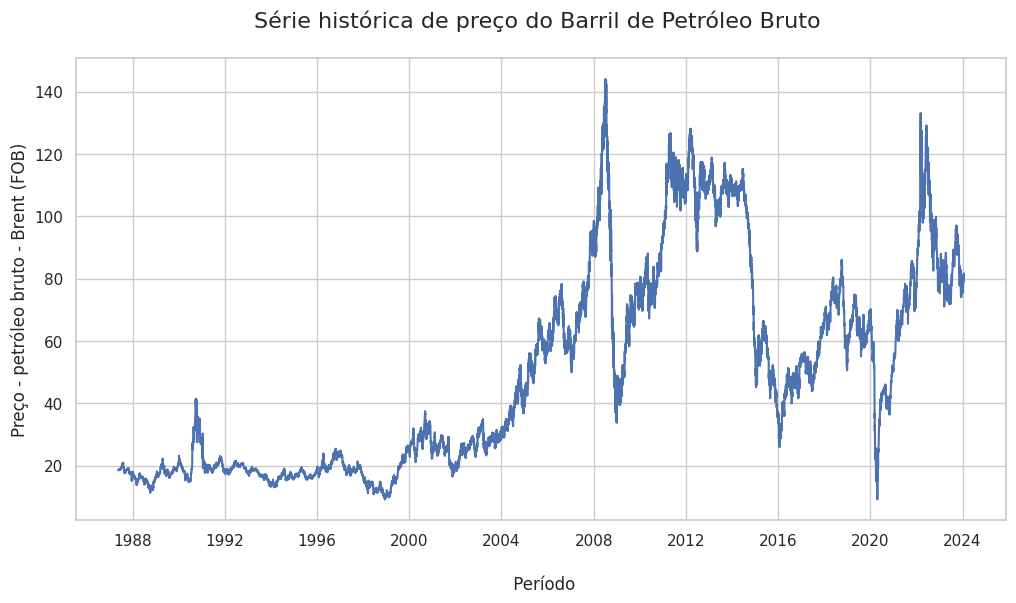

In [64]:
sns.set(style="whitegrid")
plt.figure(figsize =(12,6))
ax = sns.lineplot(data = df_petroleo, x='data', y='preco')
plt.title('Série histórica de preço do Barril de Petróleo Bruto \n', fontsize = '16')
plt.xlabel('\n Período', fontsize = 12)
plt.ylabel('Preço - petróleo bruto - Brent (FOB)', fontsize = 12)
ax=ax
ax.plot()

## **Machine Learning - Relizando a previsão com modelos de Séries Temporais**

Por se tratar de séries temporais e o objetivo do trabalho é previsão iremos instalar e testar o modelo na seguinte biblioteca:

- Prophet


### **Prophet**

In [65]:
#Instalando a biblioteca PROPHET

!pip install PROPHET


In [66]:
#Chamando as bibliotecas Prophet e SKLearn com o train_test_split para separar bases de teste e treino
from prophet import Prophet

In [67]:
#Para começarmos a trabalhar com o Prophet é necessário fazer algumas mudanças no dataframe, pra que ele não seja alterado de forma definitiva criamos
#um novo df, exclusivo para o modelo, alterando a coluna 'data' para 'ds' e 'preco' para 'y'

df_prop = df_petroleo.rename(columns={'data':'ds','preco':'y'})

In [68]:
#conferindo as mudanças

df_prop.head()

,ds,y
0,2024-01-22,81.70
1,2024-01-19,80.71
2,2024-01-18,81.04
3,2024-01-17,78.88
4,2024-01-16,80.15


In [69]:
df_prop.shape

(11092, 2)

In [70]:
df_prop.info() #analisando os tipos das variáveis para analisar se há necessidade de conversão

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      11092 non-null  object 
 1   y       11092 non-null  float64
dtypes: float64(1), object(1)
memory usage: 173.4+ KB


In [71]:
df_prop['ds'] = pd.to_datetime(df_prop['ds']) #convertendo ds de object para datetime

In [72]:
df_prop.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [73]:
#Filtrando o dataframe para pegar os ultimos
df_20= df_prop[df_prop['ds'] >= '2004-01-01']
df_10= df_prop[df_prop['ds'] >= '2014-01-01']

In [74]:
df_10.tail()

,ds,y
3061,2014-01-07,106.57
3062,2014-01-06,107.94
3063,2014-01-04,109.95
3064,2014-01-03,110.47
3065,2014-01-02,107.94


[]

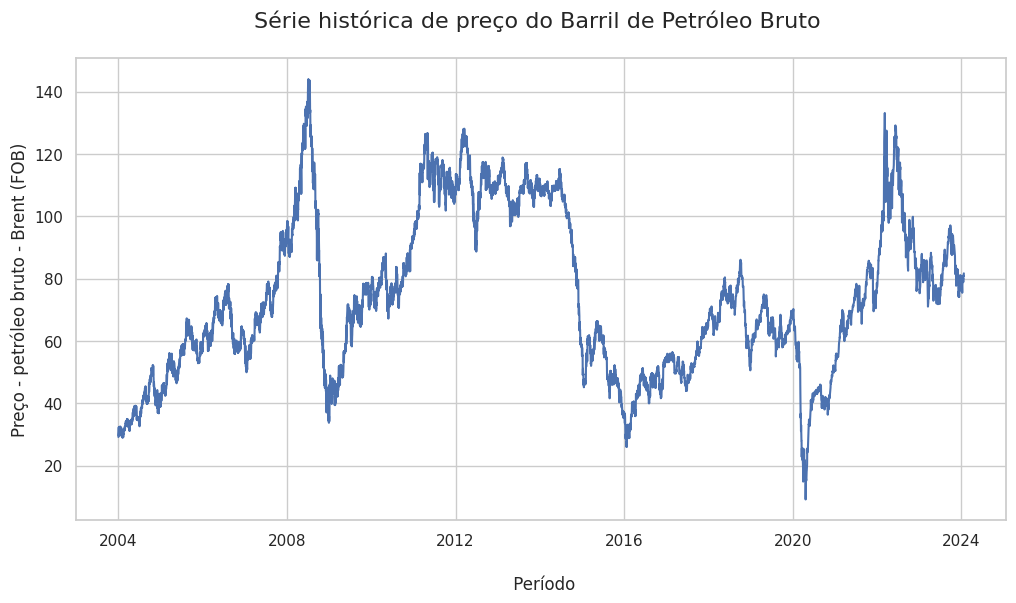

In [75]:
#Série histórica dos ultimos 20 anos
sns.set(style="whitegrid")
plt.figure(figsize =(12,6))
ax = sns.lineplot(data = df_20, x='ds', y='y')
plt.title('Série histórica de preço do Barril de Petróleo Bruto \n', fontsize = '16')
plt.xlabel('\n Período', fontsize = 12)
plt.ylabel('Preço - petróleo bruto - Brent (FOB)', fontsize = 12)
ax=ax
ax.plot()

[]

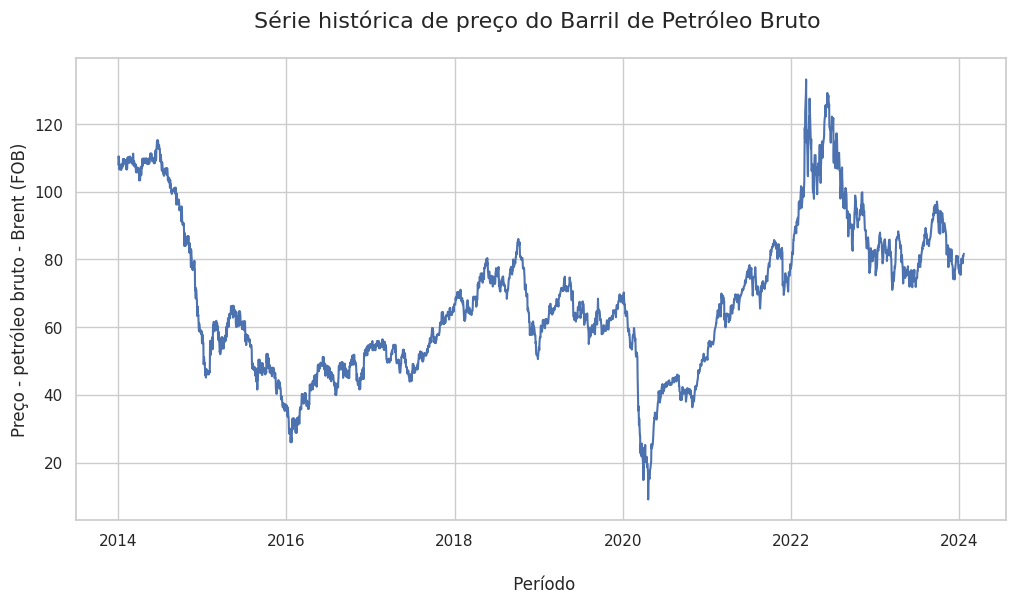

In [76]:
sns.set(style="whitegrid")
plt.figure(figsize =(12,6))
ax = sns.lineplot(data = df_10, x='ds', y='y')
plt.title('Série histórica de preço do Barril de Petróleo Bruto \n', fontsize = '16')
plt.xlabel('\n Período', fontsize = 12)
plt.ylabel('Preço - petróleo bruto - Brent (FOB)', fontsize = 12)
ax=ax
ax.plot()

### **Executando o modelo de previsão com o df_10, que corresponde aos últimos 10 anos como base.**

In [77]:
#criando uma variável para o modelo
m_prop = Prophet() #todos os ajustes de hiperparâmetros do modelo foram realizados dentro do ambiente virtual do streamlit

In [78]:
#treinando o modelo - efetuando o treinamento do modelo considerando o periodo dos ultimos 10 anos para previsões
m_prop.fit(df_10)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxq59k02/gdqxphgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxq59k02/z64wg8mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10000', 'data', 'file=/tmp/tmpyxq59k02/gdqxphgr.json', 'init=/tmp/tmpyxq59k02/z64wg8mm.json', 'output', 'file=/tmp/tmpyxq59k02/prophet_model7kfj7nuz/prophet_model-20240129144154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [79]:
future = m_prop.make_future_dataframe(periods=90) #Próximos 90 dias de previsão
future.tail()

,ds
3151,2024-04-17
3152,2024-04-18
3153,2024-04-19
3154,2024-04-20
3155,2024-04-21


In [80]:
forecast = m_prop.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3151,2024-04-17,86.536712,75.025604,97.115395,85.417617,87.639035,-0.423999,-0.423999,-0.423999,-0.071468,-0.071468,-0.071468,-0.352531,-0.352531,-0.352531,0.0,0.0,0.0,86.112713
3152,2024-04-18,86.534290,74.511028,96.751537,85.390299,87.662162,-0.435776,-0.435776,-0.435776,-0.121716,-0.121716,-0.121716,-0.314060,-0.314060,-0.314060,0.0,0.0,0.0,86.098513
3153,2024-04-19,86.531867,75.728657,96.602908,85.362981,87.705360,-0.188524,-0.188524,-0.188524,0.094957,0.094957,0.094957,-0.283481,-0.283481,-0.283481,0.0,0.0,0.0,86.343344
3154,2024-04-20,86.529445,75.092100,96.474220,85.337982,87.730188,-0.567557,-0.567557,-0.567557,-0.309082,-0.309082,-0.309082,-0.258475,-0.258475,-0.258475,0.0,0.0,0.0,85.961888
3155,2024-04-21,86.527022,76.134024,97.687069,85.313154,87.761692,-0.186269,-0.186269,-0.186269,0.050269,0.050269,0.050269,-0.236538,-0.236538,-0.236538,0.0,0.0,0.0,86.340753


In [81]:
#Analinsando as previsões feitas pelo modelo e o intervalo de confiança

principal = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
principal.tail(30) #Pegamos a cauda que nos da os ultimos valores de previsao

#ds - datas
#yhat - target previsão
#yhat_lower/upper - intervalo de confiança

,ds,yhat,yhat_lower,yhat_upper
3126,2024-03-23,83.530722,72.183942,94.524848
3127,2024-03-24,83.814279,72.469679,93.923130
3128,2024-03-25,83.970804,73.047966,94.950384
3129,2024-03-26,83.810157,72.304424,94.613497
3130,2024-03-27,83.648761,72.875365,94.710799
3131,2024-03-28,83.642158,72.354485,94.936218
3132,2024-03-29,83.928692,74.249190,95.206010
3133,2024-03-30,83.618251,72.884802,93.802579
3134,2024-03-31,84.092051,73.525276,94.685942
3135,2024-04-01,84.425581,72.880182,94.932125


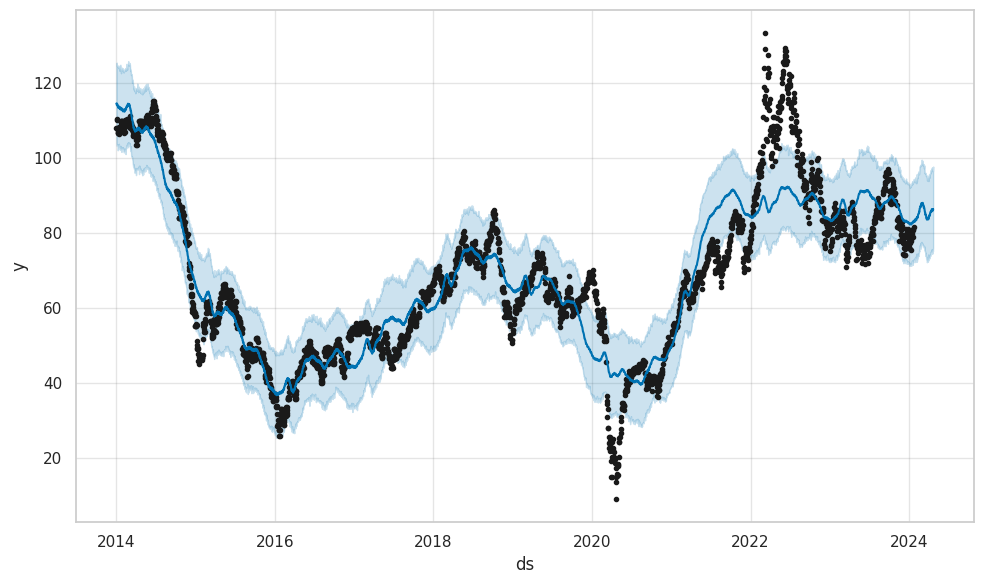

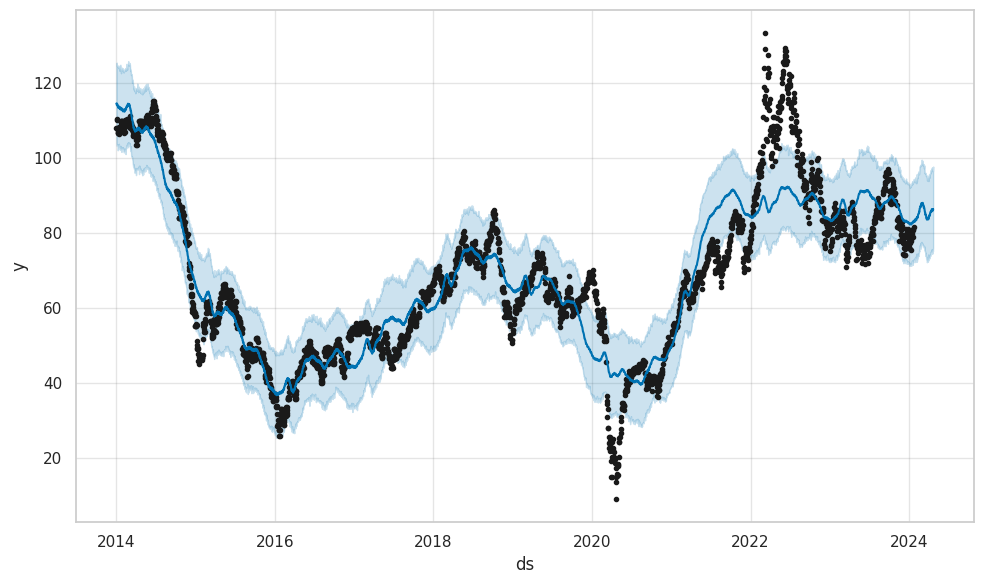

In [82]:
m_prop.plot(forecast)

Text(77.375, 0.5, 'Valores Previstos')

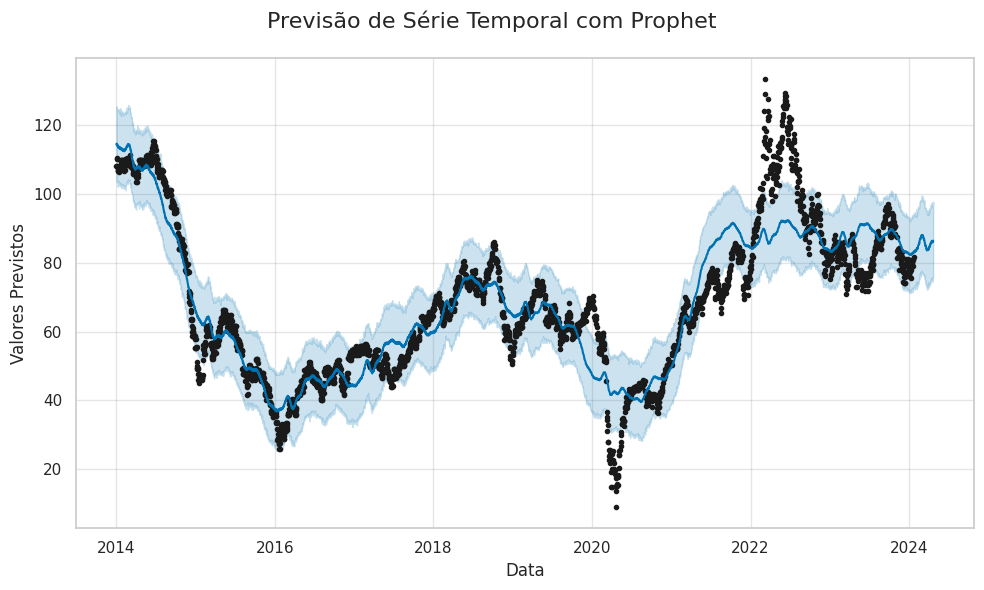

In [83]:
fig = m_prop.plot(forecast, figsize = (10,6))
fig.suptitle('Previsão de Série Temporal com Prophet', fontsize=16)
fig.subplots_adjust(top=0.9)  # Ajusta a posição do título
plt.xlabel('Data')
plt.ylabel('Valores Previstos')

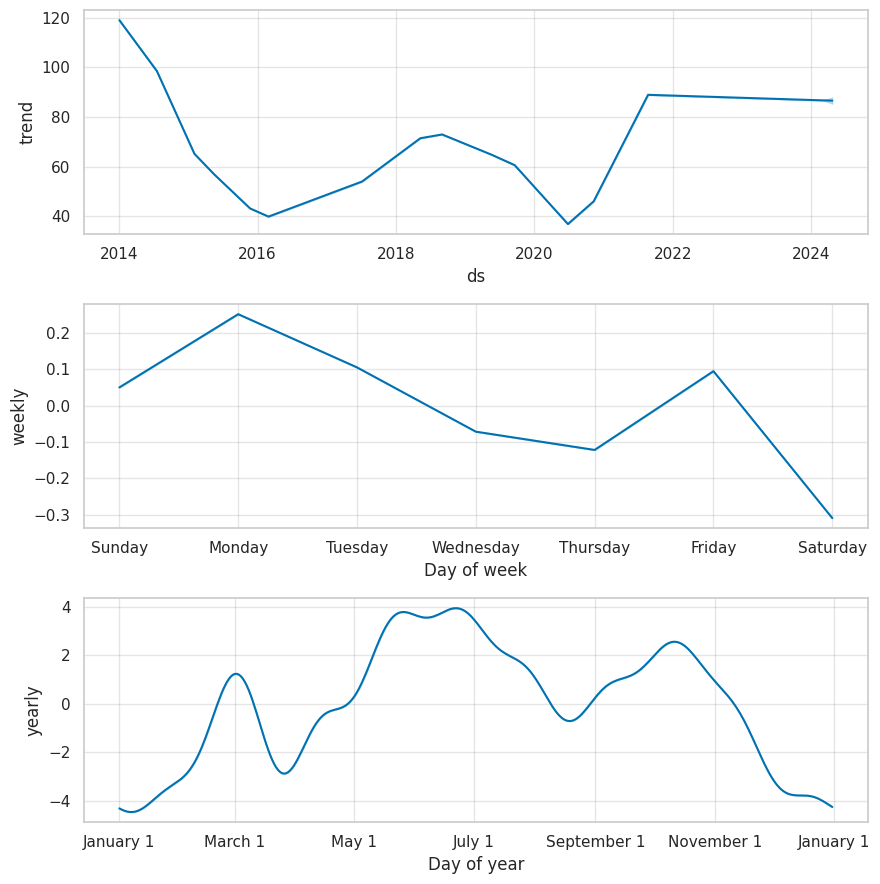

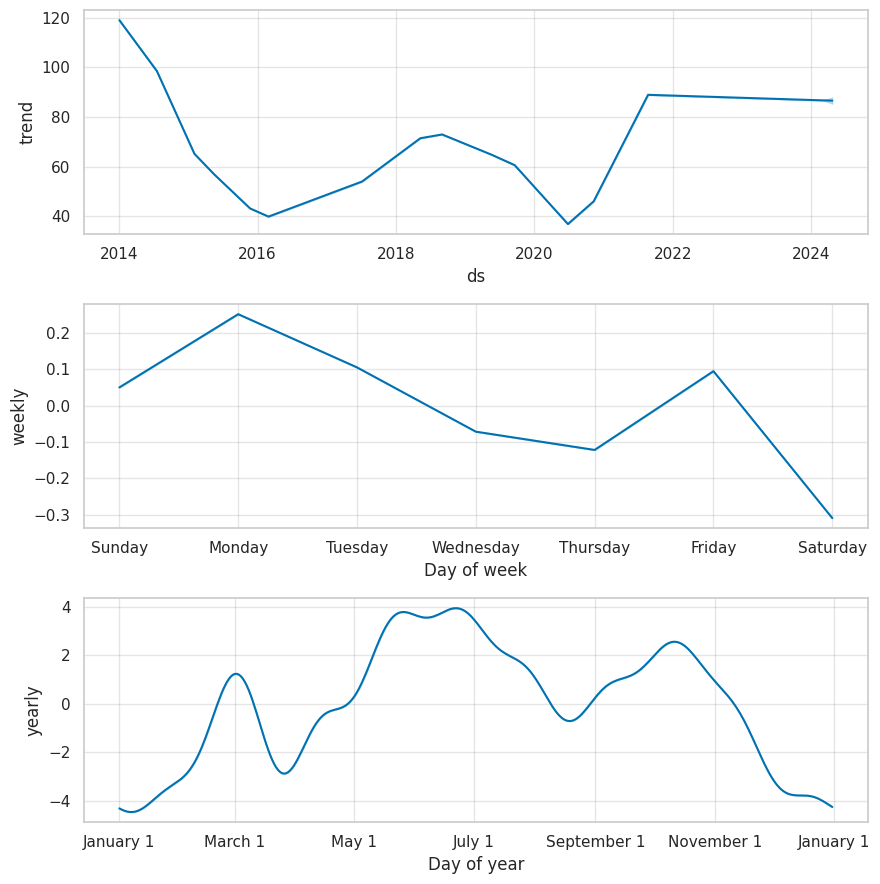

In [84]:
m_prop.plot_components(forecast)